# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from setup import *

In [30]:
import contextily as ctx

In [3]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/07/25 08:08:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/07/25 08:08:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/07/25 08:08:57 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/07/25 08:08:57 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


## Load data

### Boundary

In [4]:
bound = gpd.read_parquet(P.data / 'export/boundary.parquet').set_crs(CRS_DEG).disp()

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: EPSG:4326


geoid    aland   awater  \
     <category>  <int64>  <int64>   
0  181379685003  2566010    39626   

                                            geometry     scale      name  
                                          <geometry>  <object>  <object>  
0  POLYGON ((-85.20815 39.304011, -85.208134 39.3...        BG      None

### EJScreen

In [5]:
ejs = pd.read_parquet(P.data / 'export/ejs.parquet').disp()

356,286 rows x 7 cols; Memory: 5.8 MiB


scale  is_ses is_derived is_pctile           variable        geoid  \
   <category>  <bool>     <bool>    <bool>         <category>   <category>   
0       Tract    True      False     False  Total: Population  18001030100   

       value  
   <float64>  
0     4826.0

### AAA Access

In [6]:
aaa = pd.read_parquet(P.data / 'export/aaa.parquet').disp()

1,743,792 rows x 8 cols; Memory: 32.3 MiB


scale        mode tt_thresh  is_rac    category subcategory  \
   <category>  <category>   <int64>  <bool>  <category>  <category>   
0          BG   Bicycling        15   False     Overall       Total   

          geoid num_jobs  
     <category>  <int32>  
0  180010301001      154

### POI access

# Explore

## AAA

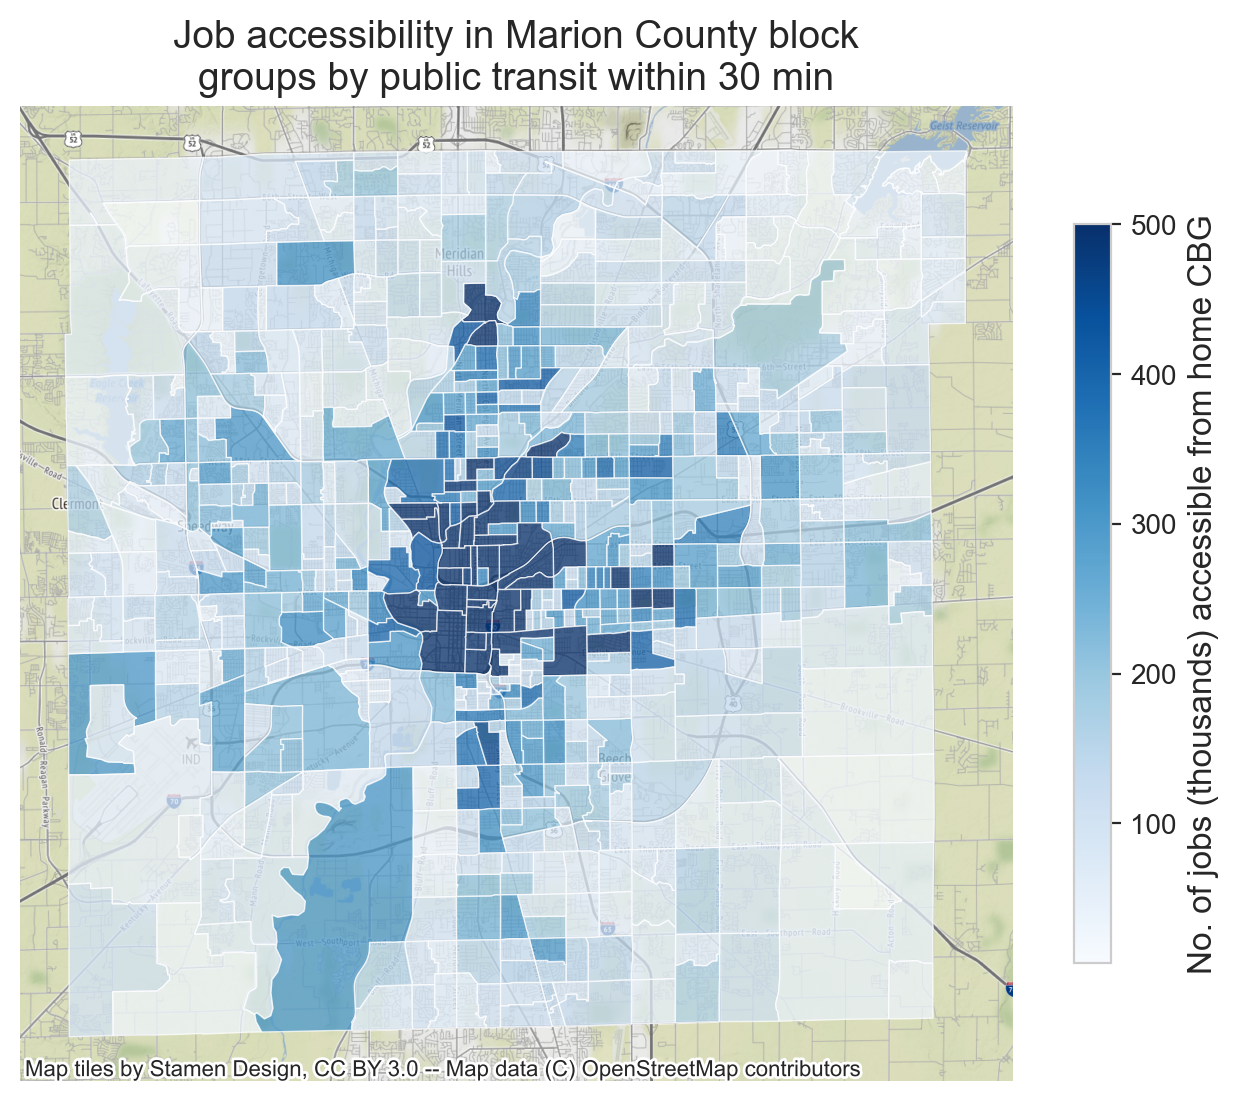

In [52]:
df = aaa.query('scale=="BG" & mode=="Transit" & tt_thresh==30 & category=="Overall" & is_rac')
df = df[df['geoid'].str.startswith(bound.query('name=="Marion"')['geoid'].iloc[0])]
df = bound.merge(df, on='geoid').to_crs(CRS_M).assign(num_jobs=lambda df: df['num_jobs'] / 1e3)
ax = U.plot(size=(8, 8), dpi=200, axoff=1, title='Job accessibility in Marion County block\ngroups by public transit within 30 min')
df.plot(ax=ax, column='num_jobs', alpha=0.75, edgecolor='w', lw=0.5, cmap='Blues', vmax=500, legend=True,
        legend_kwds=dict(shrink=0.6, label='No. of jobs (thousands) accessible from home CBG'))
ctx.add_basemap(ax=ax, crs=CRS_M);

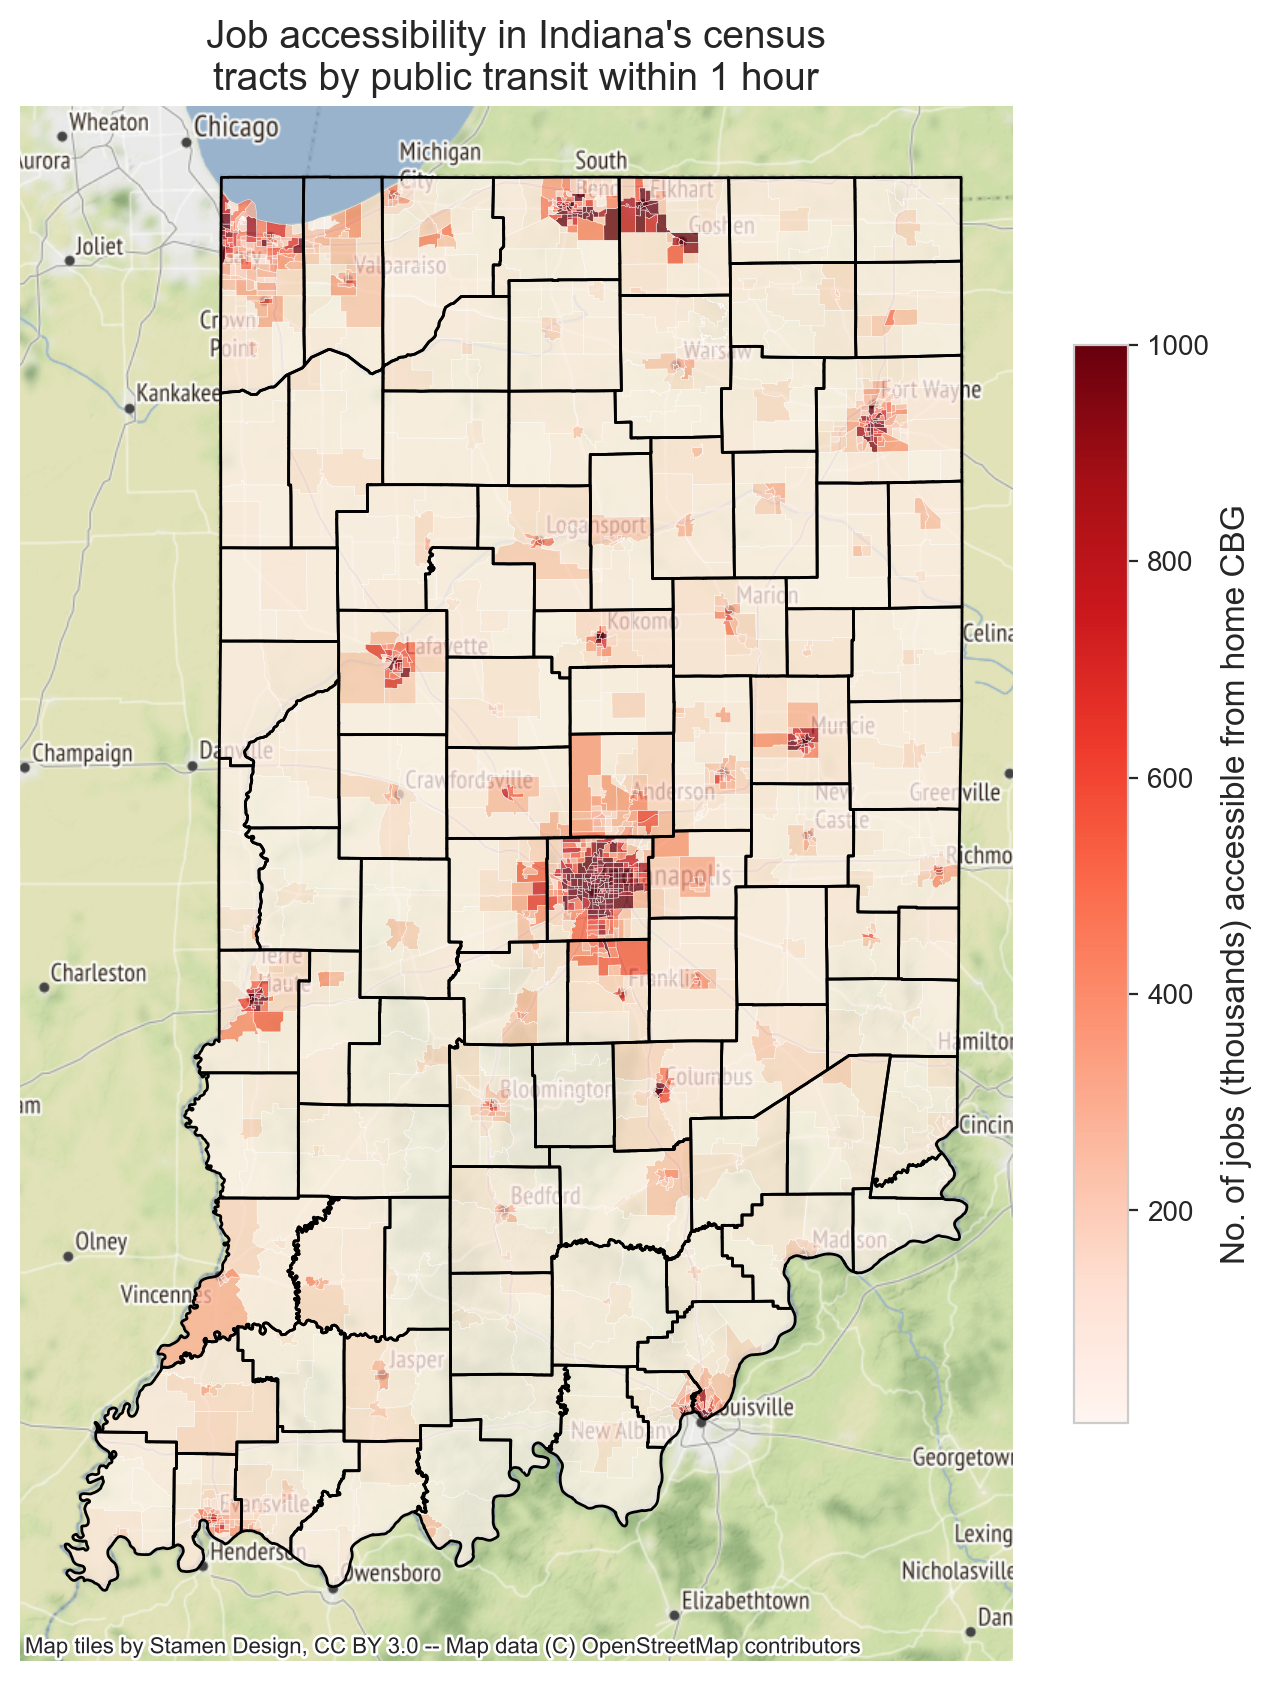

In [54]:
df = aaa.query('scale=="Tract" & mode=="Transit" & tt_thresh==60 & is_rac & category=="Job earnings" & subcategory=="Low (<$1,250/mo)"')
df = bound.merge(df, on='geoid').to_crs(CRS_M).assign(num_jobs=lambda df: df['num_jobs']/1e3)
ax = U.plot(size=(8, 14), dpi=200, axoff=1, title='Job accessibility in Indiana\'s census\ntracts by public transit within 1 hour')
df.plot(ax=ax, column='num_jobs', alpha=0.75, edgecolor='w', lw=0.2, cmap='Reds', vmax=1e3, legend=True,
        legend_kwds=dict(shrink=0.5, label='No. of jobs (thousands) accessible from home CBG'))
bound.query('scale=="County"').to_crs(CRS_M).plot(ax=ax, facecolor='none', edgecolor='k', lw=1)
ctx.add_basemap(ax=ax, crs=CRS_M);

## EJS

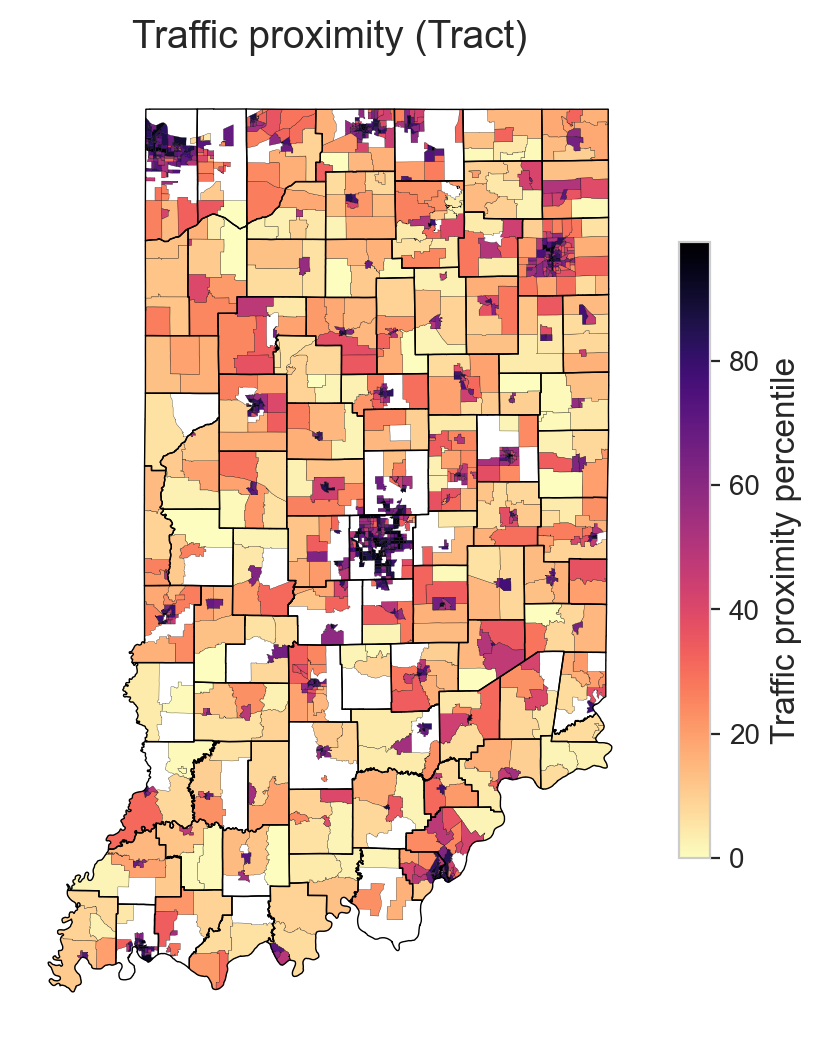

In [7]:
def plot_ejs_map(var, scale, ejs=ejs, cmap='magma_r', size=(5, 10), dpi=120):
    ejs = ejs.query(f'scale=="{scale}" & variable=="{var}" & is_pctile')
    counties = gpd.read_parquet(P.data / 'boundary/county.parquet')
    zones = gpd.read_parquet(P.data / f'boundary/{scale.lower()}.parquet')
    ejs = zones[['geoid', 'geometry']].merge(ejs, on='geoid')
    ax = U.plot(size=size, dpi=dpi, axoff=1, title=f'{var} ({scale})')
    ejs.plot(ax=ax, column='value', cmap=cmap,
             edgecolor='k', lw=0.1, legend=True,
             legend_kwds=dict(shrink=0.4, label=var + ' percentile'))
    counties.plot(ax=ax, facecolor='none', edgecolor='k', lw=0.5)

plot_ejs_map('Traffic proximity', 'Tract', dpi=200) # t=0:07

## Correlation

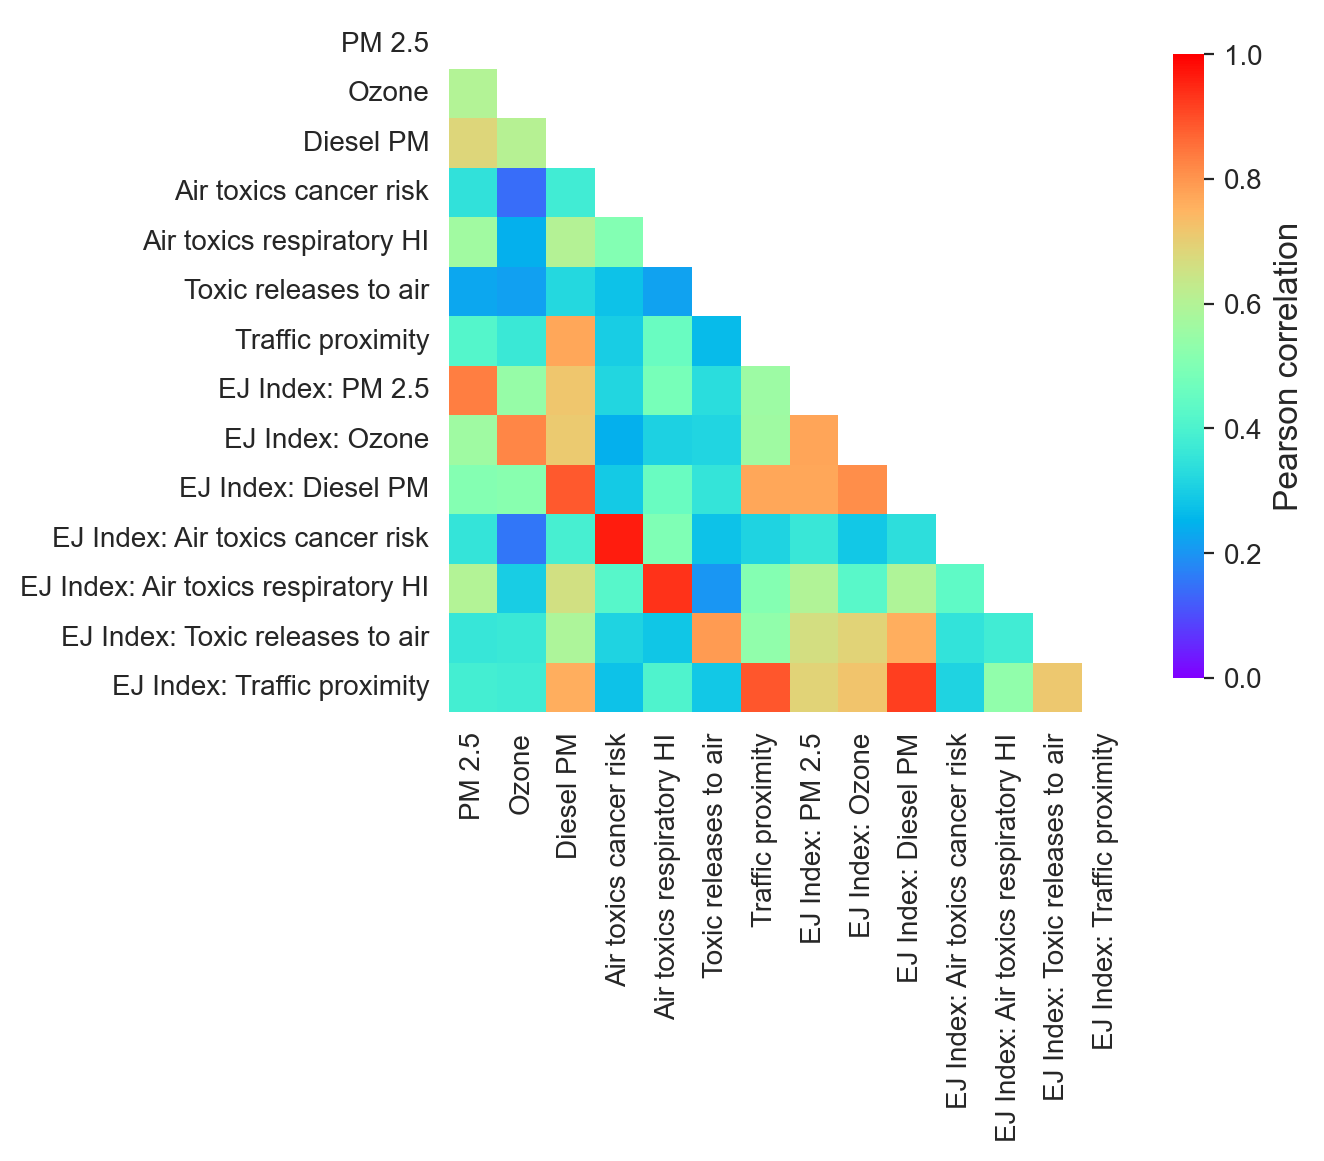

In [44]:
def plot_corr_ejs(query, df=ejs, vmin=0, vmax=1, lower=True, 
                  cmap='rainbow', size=(5.5, 4.5), dpi=100):
    df = df.query(query).dropna().pivot(
        index='geoid', columns=['is_derived', 'variable'],
        values='value').droplevel(0, axis=1).corr()
    corr = np.tril(df.values, -1)
    corr[corr == 0] = np.nan
    ax = U.plot(size=size, dpi=dpi, gridcolor='w')
    df = Pdf(corr, index=df.index, columns=df.columns)
    ax = sns.heatmap(df, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                     cbar_kws=dict(label='Pearson correlation', shrink=0.9))
    ax.set_xlabel('')
    ax.set_ylabel('')

plot_corr_ejs('scale=="Tract" & ~is_ses & is_pctile', dpi=200)

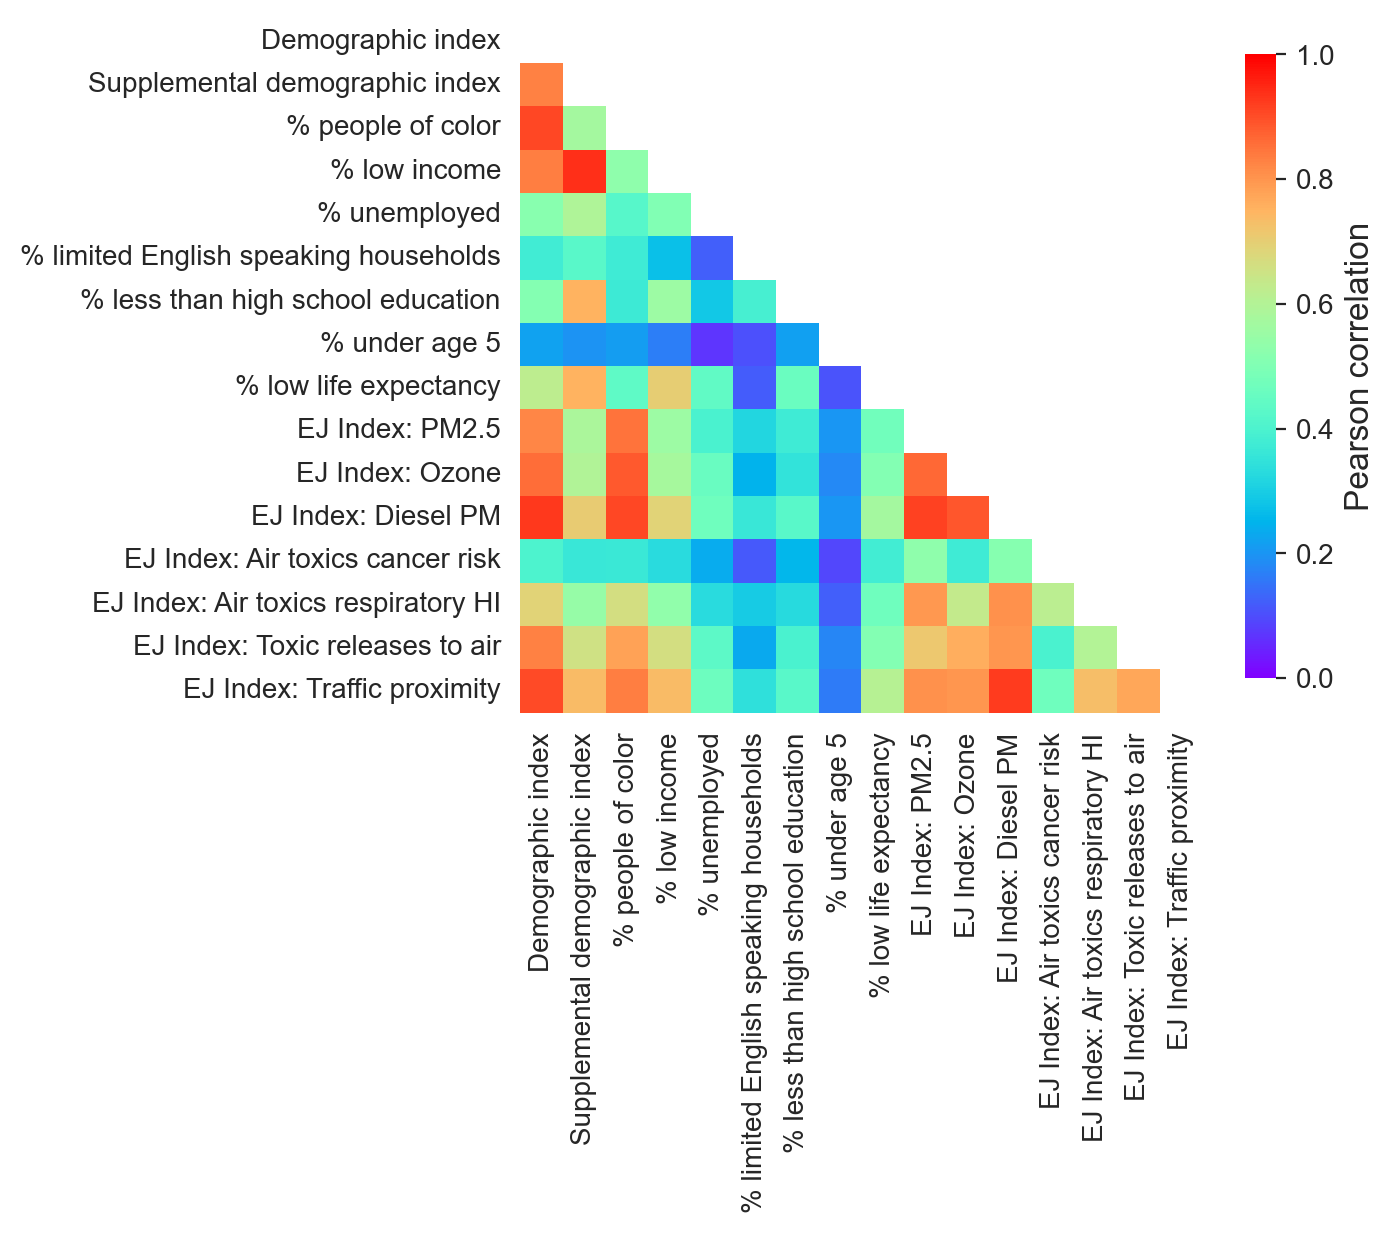

In [45]:
plot_corr_ejs('scale=="Tract" & is_derived & ~is_pctile', dpi=200)

## Plot maps

In [46]:
indy_counties = ['Boone','Brown','Hamilton','Hancock','Hendricks','Johnson','Madison','Marion','Morgan','Putnam','Shelby']

In [47]:
bgs = (bound.query('scale=="BG"').assign(county_fips=lambda df: df['geoid'].str.slice(0, 5))
       .merge(bound.merge(Pdf({'name': indy_counties}))['geoid'].rename('county_fips'))
       .set_crs(CRS_DEG)).disp()

1,178 rows x 7 cols; Memory: 0.9 MiB; CRS: EPSG:4326


geoid     aland   awater  \
     <category>   <int64>  <int64>   
0  180816112003  50259791   412098   

                                            geometry     scale      name  \
                                          <geometry>  <object>  <object>   
0  POLYGON ((-86.02792 39.37482, -86.027911 39.37...        BG      None   

  county_fips  
     <object>  
0       18081

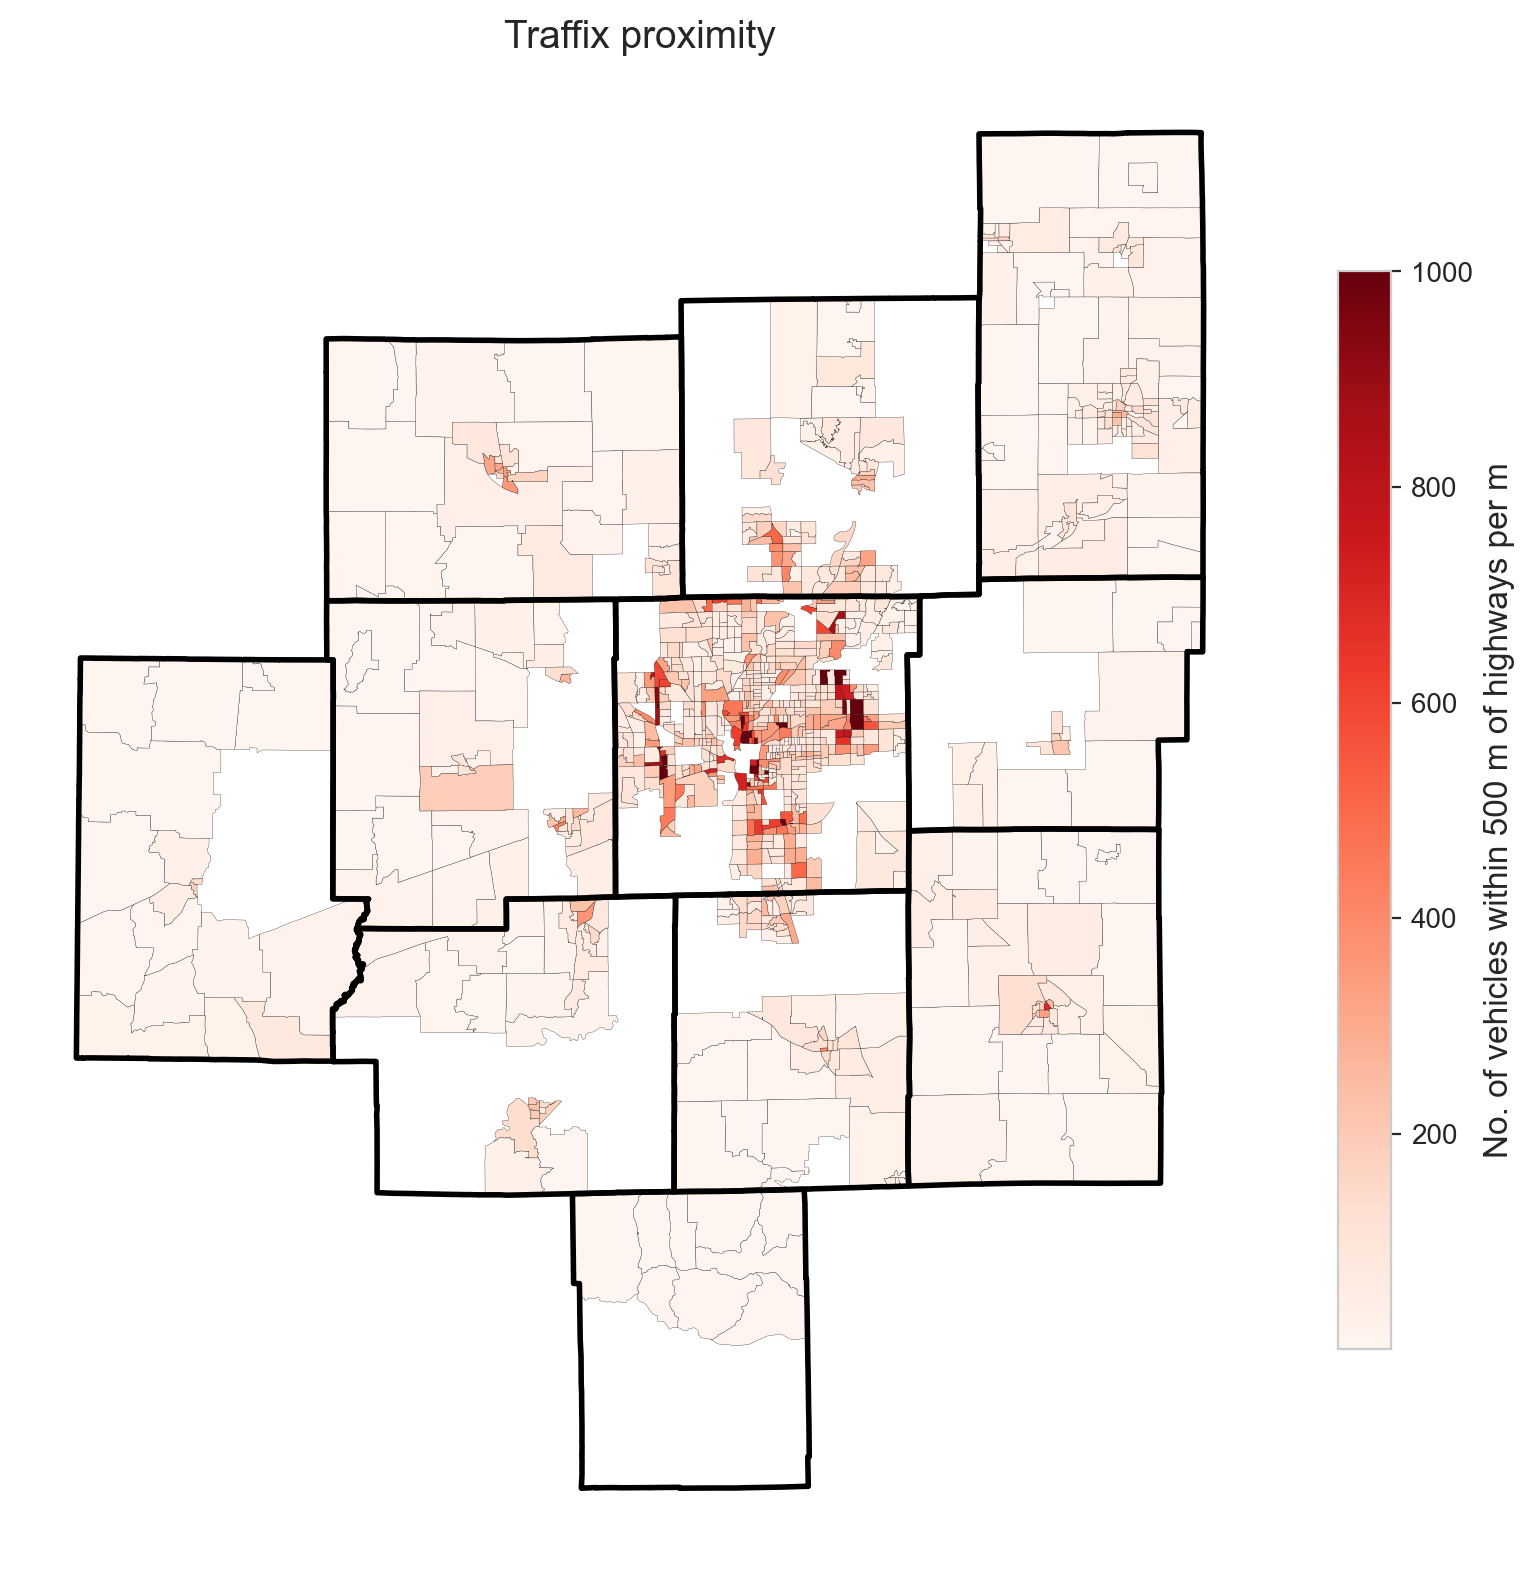

In [51]:
ax = U.plot(size=(10, 10), dpi=200, axoff=1, title='Traffix proximity')
(bgs.to_crs(CRS_M).merge(ejs.query(
    'scale=="BG" & variable=="Traffic proximity" & ~is_pctile'))
 .plot(ax=ax, column='value', cmap='Reds', linewidth=0.1,
       edgecolor='k', vmax=1000, legend=True, legend_kwds=dict(
           shrink=0.7, label='No. of vehicles within 500 m of highways per m')))
(bound.merge(Pdf({'name': indy_counties})).to_crs(CRS_M)
 .plot(ax=ax, edgecolor='k', facecolor='none', linewidth=2));

In [34]:
ses = (ejs.query('ej_or_ses=="SES" & value_or_pctile=="Percentile"')
       .pivot('geoid', 'variable', 'value').astype(int))
ses.columns = ['demographic_index', 'pct_people_of_color', 'pct_low_income', 'pct_unemployed', 
               'pct_limited_english', 'pct_low_education', 'pct_infants', 'pct_seniors']
ses = bound[['geoid', 'scale', 'name', 'geometry']].merge(ses, on='geoid').disp(3)

5,350 rows x 12 cols; Memory: 1.2 MiB; CRS: EPSG:4326


/tmp/ipykernel_192682/3358841739.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ses = (ejs.query('ej_or_ses=="SES" & value_or_pctile=="Percentile"')


geoid     scale      name  \
       <object>  <object>  <object>   
0  181379685003        BG      None   
1  181379685002        BG      None   
2  181379685001        BG      None   

                                            geometry demographic_index  \
                                          <geometry>           <int64>   
0  POLYGON ((-85.20815 39.304011, -85.208134 39.3...                54   
1  POLYGON ((-85.236724 39.298839, -85.236543 39....                38   
2  POLYGON ((-85.218627 39.296581, -85.219221 39....                73   

  pct_people_of_color pct_low_income pct_unemployed pct_limited_english  \
              <int64>        <int64>        <int64>             <int64>   
0                  22             71             39                   0   
1                  34             48             68                  88   
2                  60             82             96                   0   

  pct_low_education pct_infants pct_seniors  
            <int64>     <int64>     <int64>  
0                23          98          61  
1                27          63          44  
2                58          88          54

In [56]:
ej = (ejs.query('ej_or_ses=="EJ" & value_or_pctile=="Percentile"')
      .pivot('geoid', 'variable', 'value')
      .rename(columns=str.strip).rename(columns={'Diesel particulate matter': 'Diesel PM'})
      [['Particulate Matter 2.5', 'Ozone', 'Diesel PM', 'Air toxics cancer risk',
        'Air toxics respiratory HI', 'Traffic proximity']])
ej = bound[['geoid', 'scale', 'name', 'geometry']].merge(ej, on='geoid').disp(3)

5,350 rows x 10 cols; Memory: 1.2 MiB; CRS: EPSG:4326


/tmp/ipykernel_192682/1279161963.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ej = (ejs.query('ej_or_ses=="EJ" & value_or_pctile=="Percentile"')


geoid     scale      name  \
       <object>  <object>  <object>   
0  181379685003        BG      None   
1  181379685002        BG      None   
2  181379685001        BG      None   

                                            geometry Particulate Matter 2.5  \
                                          <geometry>              <float64>   
0  POLYGON ((-85.20815 39.304011, -85.208134 39.3...                   47.0   
1  POLYGON ((-85.236724 39.298839, -85.236543 39....                   47.0   
2  POLYGON ((-85.218627 39.296581, -85.219221 39....                   47.0   

       Ozone  Diesel PM Air toxics cancer risk Air toxics respiratory HI  \
   <float64>  <float64>              <float64>                 <float64>   
0       23.0       10.0                    0.0                      86.0   
1       23.0       10.0                    0.0                      86.0   
2       23.0       10.0                    0.0                      86.0   

  Traffic proximity  
          <float64>  
0              73.0  
1              35.0  
2              75.0

In [68]:
def plot_map_color(df, scale, query, value_var, title, bound=bound,
                   cmap='BuPu', size=(8, 14), dpi=120):
    try:
        zones = bound.query(f'scale == "{scale}"')
        df = (df[df['scale'] == scale].query(query)
              .sort_values(value_var).reset_index(drop=True))
        df['pctile'] = (df.index + 1) / len(df) * 100
        df = zones.merge(df, on='geoid')[['geoid', 'geometry', 'pctile']]
        ax = U.plot(size=size, dpi=dpi, axoff=1)
        ax.set_title(f'{title} @ {scale}', fontsize=24)
        df.plot(ax=ax, column='pctile', cmap=cmap, legend=True, 
                legend_kwds=dict(shrink=0.5, label='Percentile value'),
                lw=0.2, edgecolor='grey')
        cnty = bound.query('scale == "County"')
        cnty.plot(ax=ax, facecolor='none', edgecolor='k', lw=1)
        P.imsave(root=P.root / 'fig/ses')
    except Exception as e:
        print(scale, query, '->', e)
    finally:
        plt.close()

In [79]:
for val in ['High (>$3,333/mo)', 'Low (<$1,250/mo)', 'Medium ($1,250–$3,333/mo)']:
    query = ' & '.join([
        'mode=="Transit"',
        'tt_thresh==30',
        'is_rac',
        'category=="Job earnings"',
        f'subcategory=="{val}"'
    ])
    plot_map_color(aaa, 'Tract', query, 'num_jobs', 'Num jobs by job earnings - ' + val, cmap='OrRd')

In [83]:
d1 = aaa.query("scale=='Tract' & mode=='Transit' & is_rac & tt_thresh==30 & category=='Job earnings' & subcategory=='Low (<$1,250/mo)'")[['geoid','num_jobs']]
d2 = ejs.query('scale=="Tract" & ej_or_ses=="SES" & value_or_pctile=="Value" & base_or_derived=="Derived" & variable=="% people of color"')[['geoid','value']]
df = d2.merge(d1, on='geoid').disp()

1,318 rows x 3 cols; Memory: 0.1 MiB


geoid      value num_jobs
      <object>  <float64>  <int32>
0  18001030100   0.064724     8825

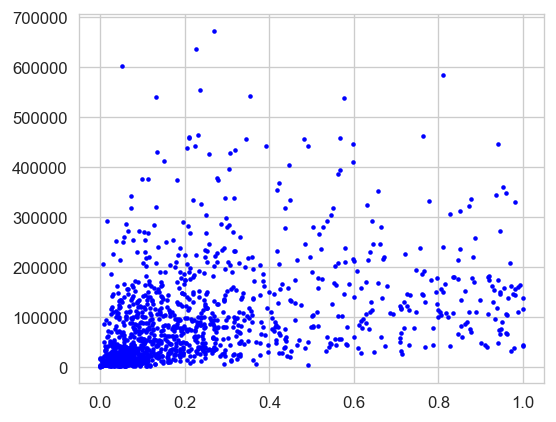

In [90]:
ax = U.plot(size=(5,4), dpi=120, xlab='')
ax.scatter(df.value, df.num_jobs, s=3, c='b')